# Cisco - Ariel University API Security Detection Challenge 2023
## Baseline code


### Imports and global settings

In [1]:
# Imports, settings and first dataset view
import pandas as pd
import seaborn as sns
import numpy as np
import json

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

# Global setting here you choose the dataset number and classification type for the model
dataset_number = 3 # Options are [1, 2, 3, 4]
test_type = 'label' # Options are ['label', 'attack_type']

# Read the json and read it to a pandas dataframe object, you can change these settings
with open(f'./dataset_{str(dataset_number)}_train.json') as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

# Shoe the first five lines of the dataframe to see if everything was read accordingly 
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,request.Attack_Tag,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Content-Length,response.headers.Location,request.headers.Cookie,response.headers.Set-Cookie
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=yGkqVSrlAG5SQ_fZmLWaNcmRrpqyDTqyfly6jHH51...,"Wed, 14 Dec 2022 23:59:27 GMT",GET,http://127.0.0.1:5000/greet/%7B%7Bget_flashed_...,,RCE,200 OK,text/html; charset=utf-8,48,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=CBhNqYCEwU1hN4CAD575di_4AcXDmw9CJAmtkmnri...,"Thu, 15 Dec 2022 00:36:21 GMT",GET,http://127.0.0.1:5000/about/greet?id=8730419.2...,,NaN,200 OK,text/html; charset=utf-8,93,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN
2,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=ZQg8nVqE2_D3CUsmSgDblTxzOkazD7RURCvUUcty_...,"Thu, 15 Dec 2022 00:47:40 GMT",GET,http://127.0.0.1:5000/static/download_txt/Inez...,,NaN,200 OK,application/json,88,200,"{""error"": ""File Inez.txtfilename=0MGnu5_DtpSPy...",NaN,NaN,NaN,NaN
3,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=3bV7UJGya8WbsvLb5oZMQfCX_kAxzzmCNHYnBZ6gd...,"Thu, 15 Dec 2022 00:45:52 GMT",GET,http://127.0.0.1:5000/categories/check/all?res...,,NaN,200 OK,application/json,871,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",NaN,NaN,NaN,NaN
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=GYA_AaxVnjLo7_TMm5qDgaJwuKEWzzJ3SU3UlNLqY...,"Thu, 15 Dec 2022 00:48:06 GMT",GET,http://127.0.0.1:5000/orders/get/id/4581?id=62...,,NaN,404 NOT FOUND,application/json,31,404,"{""error"": ""Order ID not found""}",NaN,NaN,NaN,NaN


### Basic dataset label arrangements

In [2]:
# Fill the black attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

# This function will be used in the lambda below to iterate over the label columns 
# You can use this snippet to run your own lambda on any data with the apply() method
def categorize(row):  
    if row['request.Attack_Tag'] == 'Benign':
        return 'Benign'
    return 'Malware'

df['label'] = df.apply(lambda row: categorize(row), axis=1)

# After finishing the arrangements we delete the irrelevant column
df.drop('request.Attack_Tag', axis=1, inplace=True)

df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Content-Length,response.headers.Location,request.headers.Cookie,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=yGkqVSrlAG5SQ_fZmLWaNcmRrpqyDTqyfly6jHH51...,"Wed, 14 Dec 2022 23:59:27 GMT",GET,http://127.0.0.1:5000/greet/%7B%7Bget_flashed_...,,200 OK,text/html; charset=utf-8,48,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN,RCE,Malware
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=CBhNqYCEwU1hN4CAD575di_4AcXDmw9CJAmtkmnri...,"Thu, 15 Dec 2022 00:36:21 GMT",GET,http://127.0.0.1:5000/about/greet?id=8730419.2...,,200 OK,text/html; charset=utf-8,93,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN,Benign,Benign
2,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=ZQg8nVqE2_D3CUsmSgDblTxzOkazD7RURCvUUcty_...,"Thu, 15 Dec 2022 00:47:40 GMT",GET,http://127.0.0.1:5000/static/download_txt/Inez...,,200 OK,application/json,88,200,"{""error"": ""File Inez.txtfilename=0MGnu5_DtpSPy...",NaN,NaN,NaN,NaN,Benign,Benign
3,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=3bV7UJGya8WbsvLb5oZMQfCX_kAxzzmCNHYnBZ6gd...,"Thu, 15 Dec 2022 00:45:52 GMT",GET,http://127.0.0.1:5000/categories/check/all?res...,,200 OK,application/json,871,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",NaN,NaN,NaN,NaN,Benign,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=GYA_AaxVnjLo7_TMm5qDgaJwuKEWzzJ3SU3UlNLqY...,"Thu, 15 Dec 2022 00:48:06 GMT",GET,http://127.0.0.1:5000/orders/get/id/4581?id=62...,,404 NOT FOUND,application/json,31,404,"{""error"": ""Order ID not found""}",NaN,NaN,NaN,NaN,Benign,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144495,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) G...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=CUsow_eOa54yp9oNsd1BhZF2lKtgt-PGMG7iBnLba...,"Thu, 15 Dec 2022 00:49:47 GMT",GET,http://127.0.0.1:5000/?res_id=kc66M-9P2z2nOc6C...,,200 OK,text/html; charset=utf-8,34,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN,Benign,Benign
144496,127.0.0.1:5000,python-requests/2.28.1,"gzip, deflate",*/*,keep-alive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GET,http://127.0.0.1:5000/bookstore,,200 OK,application/json,41,200,"{""message"": ""Welcome to the Book Store!""}",NaN,NaN,NaN,NaN,Benign,Benign
144497,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; r...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=wo-zV78-fKpHPJjNrkXs_EyYZNCJ_VErr0hf4O8l1...,"Thu, 15 Dec 2022 00:47:04 GMT",GET,http://127.0.0.1:5000/greet/Manuel,,200 OK,text/html; charset=utf-8,22,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN,Benign,Benign
144498,127.0.0.1:5000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,websocket,?1,document,['ck=2mYff-_R_5fjojY_G5JZQ1uiY-WO6gdfN09c9nH_R...,"Thu, 15 Dec 2022 00:42:00 GMT",GET,http://127.0.0.1:5000/orders/get/random/6,,200 OK,application/json,20,200,"[{}, {}, {}, {}, {}, {}]",NaN,NaN,NaN,NaN,Benign,

In [3]:
# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
for column in df.columns[df.isna().any()].tolist():
    # df.drop(column, axis=1, inplace=True)
    df[column] = df[column].fillna('None')
    
# If you want to detect columns that may have only some NaN values use this:
# df.loc[:, df.isna().any()].tolist()

df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Content-Length,response.headers.Location,request.headers.Cookie,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=yGkqVSrlAG5SQ_fZmLWaNcmRrpqyDTqyfly6jHH51...,"Wed, 14 Dec 2022 23:59:27 GMT",GET,http://127.0.0.1:5000/greet/%7B%7Bget_flashed_...,,200 OK,text/html; charset=utf-8,48,200,text/html; charset=utf-8,None,None,None,None,RCE,Malware
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=CBhNqYCEwU1hN4CAD575di_4AcXDmw9CJAmtkmnri...,"Thu, 15 Dec 2022 00:36:21 GMT",GET,http://127.0.0.1:5000/about/greet?id=8730419.2...,,200 OK,text/html; charset=utf-8,93,200,text/html; charset=utf-8,None,None,None,None,Benign,Benign
2,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=ZQg8nVqE2_D3CUsmSgDblTxzOkazD7RURCvUUcty_...,"Thu, 15 Dec 2022 00:47:40 GMT",GET,http://127.0.0.1:5000/static/download_txt/Inez...,,200 OK,application/json,88,200,"{""error"": ""File Inez.txtfilename=0MGnu5_DtpSPy...",None,None,None,None,Benign,Benign
3,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=3bV7UJGya8WbsvLb5oZMQfCX_kAxzzmCNHYnBZ6gd...,"Thu, 15 Dec 2022 00:45:52 GMT",GET,http://127.0.0.1:5000/categories/check/all?res...,,200 OK,application/json,871,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",None,None,None,None,Benign,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=GYA_AaxVnjLo7_TMm5qDgaJwuKEWzzJ3SU3UlNLqY...,"Thu, 15 Dec 2022 00:48:06 GMT",GET,http://127.0.0.1:5000/orders/get/id/4581?id=62...,,404 NOT FOUND,application/json,31,404,"{""error"": ""Order ID not found""}",None,None,None,None,Benign,Benign


In [4]:
# # Setting features for further feature extraction by choosing columns
# # Some will be "simply" encoded via label encoding and others with HashingVectorizer

# SIMPLE_HEADERS = [ 
#                 'request.headers.Accept-Language',
#                 'request.headers.Sec-Fetch-Mode','response.status_code', 
# #     'request.headers.Sec-Fetch-Dest',
# #     'request.headers.Sec-Fetch-Site',
                  
#                 ]
# # On these headers we will run HashingVectorizer

# COMPLEX_HEADERS = ['response.headers.Content-Type','request.headers.User-Agent',
# #                     'request.headers.Set-Cookie',
#                      'response.body',
#                    'request.body',
#                    'request.url',
#                    'request.headers.Date',
#                     'response.headers.Location',
#                     'request.headers.Cookie','response.status',
# #                    lalal
# #                    'request.headers.Accept-Encoding',
#                     ]

SIMPLE_HEADERS = [ 'response.status_code',
                   'request.headers.Host',
                  'request.headers.Sec-Fetch-User',
                  'request.headers.Content-Length' ]

# On these headers we will run HashingVectorizer
COMPLEX_HEADERS = ['response.headers.Content-Type',
                   'response.body', 'response.headers.Location',
                   'request.headers.Cookie',
                   'request.body','request.url','request.method',
                   'response.status' ]


COLUMNS_TO_REMOVE = ['request.headers.User-Agent',
                     'request.headers.Date',
#                      'request.headers.Content-Length',
                    
                     'request.headers.Connection',
                     'request.headers.Accept',
                     'response.headers.Set-Cookie',
                     'request.headers.Accept-Language',
                     
                     'request.headers.Sec-Fetch-Mode']


# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):
    le = LabelEncoder()
    h_vec = HashingVectorizer(n_features=4)

    # Run LabelEncoder on the chosen features
    for column in SIMPLE_HEADERS: 
        df[column] = le.fit_transform(df[column])
    
    # Run HashingVectorizer on the chosen features
    for column in COMPLEX_HEADERS: 
        newHVec = h_vec.fit_transform(df[column])
        df[column] = newHVec.todense()

    # Remove some columns that may be needed.. (Or not, you decide)
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
    def cat(row):  
        if row['request.headers.Sec-Fetch-User'] == '?0':
            return 0
        if row['request.headers.Sec-Fetch-User'] == '?1':
            return 1
        return 0
    def cat1(row):  
        if row['request.headers.Sec-Ch-Ua-Mobile'] == '?0':
            return 0
        if row['request.headers.Sec-Ch-Ua-Mobile'] == '?1':
            return 1
        return 0
    def cat2(row):  
        if row['request.body'] == '':
            return 0
        else:
            return 1
    def cat3(row):  
        if row['request.headers.Cache-Control'] == 'max-age=0':
            return 1
        else:
            return 0
    def cat4(row):  
        if row['request.headers.Sec-Ch-Ua-Platform'] == '"Windows"':
            return 0
        if row['request.headers.Sec-Ch-Ua-Platform'] == 'None':
            return 1
        else:
            return 2

#     df['request.headers.Sec-Ch-Ua-Mobile'] = df.apply(lambda row: cat1(row), axis=1)
#     df['request.headers.Sec-Fetch-User'] = df.apply(lambda row: cat(row), axis=1)
#     df['request.body'] = df.apply(lambda row: cat2(row), axis=1)
    
#     df['request.headers.Cache-Control'] = df.apply(lambda row: cat3(row), axis=1)
#     df['request.headers.Sec-Ch-Ua-Platform'] = df.apply(lambda row: cat4(row), axis=1)
    df['request.headers.Accept-Encoding'] = np.where(df['request.headers.Accept-Encoding'].str.contains("jndi"), 1, 0)
    
    df['request.headers.Sec-Fetch-Dest'] = np.where(df['request.headers.Sec-Fetch-Dest'].str.contains("jndi:"), 1, 0)
    df['request.headers.Set-Cookie'] = np.where(df['request.headers.Set-Cookie'].str.contains("jndi"), 1, 0)
    df['request.headers.Sec-Fetch-Site'] = np.where(df['request.headers.Sec-Fetch-Site'].str.contains("jndi"), 1, 0)
    # df['request.headers.Accept-Encoding'] = np.where(df['request.headers.Accept-Encoding'].str.contains("${jndi:"), 1, 0)
    return df
df['response.headers.Content-Length'] = pd.to_numeric(df['response.headers.Content-Length'])

df = vectorize_df(df)
df.head()

,request.headers.Host,request.headers.Accept-Encoding,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Content-Length,response.headers.Location,request.headers.Cookie,attack_type,label
0,0,0,0,0,0,0,0.0,0.927173,0.0,0.707107,-1.0,48,0,-1.000000,14,-1.0,-1.0,RCE,Malware
1,0,0,0,0,0,0,0.0,0.707107,0.0,0.707107,-1.0,93,0,-1.000000,14,-1.0,-1.0,Benign,Benign
2,0,0,0,0,0,0,0.0,0.707107,0.0,0.707107,-1.0,88,0,0.377964,14,-1.0,-1.0,Benign,Benign
3,0,0,0,0,0,0,0.0,0.000000,0.0,0.707107,-1.0,871,0,-0.255551,14,-1.0,-1.0,Benign,Benign
4,0,0,0,0,0,0,0.0,0.316228,0.0,1.000000,-1.0,31,5,0.000000,14,-1.0,-1.0,Benign,Benign


# URL

In [5]:
from bs4 import BeautifulSoup
import urllib
import bs4
import re
import socket
import whois
from datetime import datetime
import time
# https://breakingcode.wordpress.com/2010/06/29/google-search-python/
# Previous package structure was modified. Import statements according to new structure added. Also code modified.
import googlesearch  as gs
# This import is needed only when you run this file in isolation.
import sys
from patterns import *
# Purpose - This file just stores all the regular expression patterns used in features_extraction.py so that there is
# a common source which can be used if any of the patterns are to be edited.

ipv4_pattern = r"^(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$"
ipv6_pattern = r"^(?:(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){6})(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):" \
               r"(?:(?:[0-9a-fA-F]{1,4})))|(?:(?:(?:(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}" \
               r"(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|(?:(?:::(?:(?:(?:[0-9a-fA-F]{1,4})):){5})" \
               r"(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):(?:(?:[0-9a-fA-F]{1,4})))|(?:(?:(?:(?:(?:25[0-5]|" \
               r"(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|" \
               r"(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})))?::(?:(?:(?:[0-9a-fA-F]{1,4})):){4})" \
               r"(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):(?:(?:[0-9a-fA-F]{1,4})))|(?:(?:(?:(?:(?:25[0-5]|" \
               r"(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|" \
               r"(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){0,1}(?:(?:[0-9a-fA-F]{1,4})))?::" \
               r"(?:(?:(?:[0-9a-fA-F]{1,4})):){3})(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):(?:(?:[0-9a-fA-F]{1,4})))|" \
               r"(?:(?:(?:(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}" \
               r"(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){0,2}" \
               r"(?:(?:[0-9a-fA-F]{1,4})))?::(?:(?:(?:[0-9a-fA-F]{1,4})):){2})(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):" \
               r"(?:(?:[0-9a-fA-F]{1,4})))|(?:(?:(?:(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}(?:(?:25[0-5]|" \
               r"(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){0,3}" \
               r"(?:(?:[0-9a-fA-F]{1,4})))?::(?:(?:[0-9a-fA-F]{1,4})):)(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):" \
               r"(?:(?:[0-9a-fA-F]{1,4})))|(?:(?:(?:(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}" \
               r"(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){0,4}" \
               r"(?:(?:[0-9a-fA-F]{1,4})))?::)(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):(?:(?:[0-9a-fA-F]{1,4})))|" \
               r"(?:(?:(?:(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}(?:(?:25[0-5]|" \
               r"(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){0,5}" \
               r"(?:(?:[0-9a-fA-F]{1,4})))?::)(?:(?:[0-9a-fA-F]{1,4})))|(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){0,6}" \
               r"(?:(?:[0-9a-fA-F]{1,4})))?::))))$"
shortening_services = r"bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|" \
                      r"yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|" \
                      r"short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|" \
                      r"doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|db\.tt|" \
                      r"qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|q\.gs|is\.gd|" \
                      r"po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|x\.co|" \
                      r"prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|" \
                      r"tr\.im|link\.zip\.net"
http_https = r"https://|http://"

In [6]:
# pip install whois

In [7]:
# pip install patterns

In [8]:
# pip install google-search

In [9]:
# !pip install google

In [10]:
def https_token(url):
    match = re.search(http_https, url)
    if match and match.start() == 0:
        url = url[match.end():]
    match = re.search('http|https', url)
    return 0 if match else 1


def having_ip_address(url):
    ip_address_pattern = ipv4_pattern + "|" + ipv6_pattern
    match = re.search(ip_address_pattern, url)
    return -1 if match else 1


def url_length(url):
    if len(url) < 54:
        return 0
    else:
        return 1



def shortening_service(url):
    match = re.search(shortening_services, url)
    
    return 1 if match else 0


def having_at_symbol(url):
    match = re.search('@', url)
    return 1 if match else 0

def having_at_symbol2(url):
    match = re.search('%', url)
    return 1 if match else 0

def double_slash_redirecting(url):
    # since the position starts from 0, we have given 6 and not 7 which is according to the document.
    # It is convenient and easier to just use string search here to search the last occurrence instead of re.
    last_double_slash = url.rfind('//')
    return 1 if last_double_slash > 6 else 0


def prefix_suffix(domain):
    match = re.search('-', domain)
    return 1 if match else 0


def having_sub_domain(url):
    # Here, instead of greater than 1 we will take greater than 3 since the greater than 1 condition is when www and
    # country domain dots are skipped
    # Accordingly other dots will increase by 1
    if having_ip_address(url) == -1:
        match = re.search(
            '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
            '([01]?\\d\\d?|2[0-4]\\d|25[0-5]))|(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}',
            url)
        pos = match.end()
        url = url[pos:]
    num_dots = [x.start() for x in re.finditer(r'\.', url)]
    if len(num_dots) <= 3:
        return 0
    else:
        return 1





def https_token(url):
    match = re.search(http_https, url)
    if match and match.start() == 0:
        url = url[match.end():]
    match = re.search('http|https', url)
    return 0 if match else 1



In [11]:
def check_url(url,domain,wiki):
    print(url)
#     if having_ip_address(url) == 1:
#         return 1
    if url_length(url)  == 1:
        print("url_length")
        return 1
    elif shortening_service(url) == 1:
        print("shortening_service")
        return 1
    elif having_at_symbol(url) == 1:
        print("having_at_symbol")
        return 1
    elif having_at_symbol2(url) == 1:
        print("having_at_symbol2")
        return 1
    elif double_slash_redirecting(url)== 1:
        return 1


# lallal
    elif prefix_suffix(domain)== 1:
        print("prefix_suffix") 
        return 1
    elif having_sub_domain(url)== 1:
        print("having_sub_domain")
        return 1
# lallal
#     elif domain_registration_length(domain)== 1:
#         return 1
# # lallal
#     elif https_token(url)== 1:
#         return 1


    else:
        return 0

In [12]:
def get_hostname_from_url(url):
    
    hostname = url
    # TODO: Put this pattern in patterns.py as something like - get_hostname_pattern.
    pattern = "https://|http://|www.|https://www.|http://www."
    pre_pattern_match = re.search(pattern, hostname)

    if pre_pattern_match:
        hostname = hostname[pre_pattern_match.end():]
        post_pattern_match = re.search("/", hostname)
        if post_pattern_match:
            hostname = hostname[:post_pattern_match.start()]

    return hostname

In [13]:

# hostname=get_hostname_from_url("http://127.0.0.1:5000/static/download_txt/../../../../../../../../windows.ini.txt")
# domain = whois.query(hostname)
# print(check_url("http://127.0.0.1:5000/static/download_txt/../../../../../../../../windows.ini.txt",domain,hostname))

In [14]:
def change_url(df):  
    df_url=[]
    for index, row in df.iterrows():
        url=row["request.url"]
        hostname=get_hostname_from_url(url)
        domain=""
        try:
            domain = whois.query(hostname)
        except:
             dns = -1
        df_url.append(check_url(url,domain,hostname))

    # print(df.length())
    # print(df_url)
    # for index, row in df.iterrows():
    df["request.url"] =df_url
    return df


In [15]:

# change_url(df)

In [16]:
print (df["request.url"])

0         0.927173
1         0.707107
2         0.707107
3         0.000000
4         0.316228
            ...   
144495    0.948683
144496    0.707107
144497    0.894427
144498    0.000000
144499    0.000000
Name: request.url, Length: 144500, dtype: float64


In [17]:
# removing columns with the same values
print("Before: " ,df.shape)
for col in df.columns:
    if len(df[col].unique()) == 1:
        # print("col drop: ",col)
        df = df.drop(col,axis=1)

print("After: " ,df.shape)

Before:  (144500, 19)
After:  (144500, 17)


In [18]:
# Memory check (For large datasets sometimes the dataframe will exceed the computers resources)
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144500 entries, 0 to 144499
Data columns (total 17 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   request.headers.Accept-Encoding  144500 non-null  int32  
 1   request.headers.Sec-Fetch-Site   144500 non-null  int32  
 2   request.headers.Sec-Fetch-User   144500 non-null  int32  
 3   request.headers.Sec-Fetch-Dest   144500 non-null  int32  
 4   request.headers.Set-Cookie       144500 non-null  int32  
 5   request.method                   144500 non-null  float64
 6   request.url                      144500 non-null  float64
 7   request.body                     144500 non-null  float64
 8   response.status                  144500 non-null  float64
 9   response.headers.Content-Length  144500 non-null  int64  
 10  response.status_code             144500 non-null  int64  
 11  response.body                    144500 non-null  float64
 12  re

In [19]:
# Choose the right features
# In our example code we choose all the columns as our feature this can be the right or wrong way to approach the model, you choose.

features_list = df.columns.to_list()
features_list.remove('label')
features_list.remove('attack_type')
print(features_list)

# Recheck all datatype before training to see we don't have any objects in our features
# In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing
df.dtypes

['request.headers.Accept-Encoding', 'request.headers.Sec-Fetch-Site', 'request.headers.Sec-Fetch-User', 'request.headers.Sec-Fetch-Dest', 'request.headers.Set-Cookie', 'request.method', 'request.url', 'request.body', 'response.status', 'response.headers.Content-Length', 'response.status_code', 'response.body', 'request.headers.Content-Length', 'response.headers.Location', 'request.headers.Cookie']


request.headers.Accept-Encoding      int32
request.headers.Sec-Fetch-Site       int32
request.headers.Sec-Fetch-User       int32
request.headers.Sec-Fetch-Dest       int32
request.headers.Set-Cookie           int32
request.method                     float64
request.url                        float64
request.body                       float64
response.status                    float64
response.headers.Content-Length      int64
response.status_code                 int64
response.body                      float64
request.headers.Content-Length       int32
response.headers.Location          float64
request.headers.Cookie             float64
attack_type                         object
label                               object
dtype: object

## Train test split

In [20]:
# Data train and test split preparations. Here we will insert our feature list and label list.
# Afterwards the data will be trained and fitted on the amazing XGBoost model
# X_Train and y_Train will be used for training
# X_test and y_test.T will be used for over fitting checking and overall score testing

# We convert the feature list to a numpy array, this is required for the model fitting
X = df[features_list].to_numpy()

# This column is the desired prediction we will train our model on
y = np.stack(df[test_type])

# We split the dataset to train and test according to the required ration
# Do not change the test_size -> you can change anything else
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1765, random_state=42, stratify=y)

# We print the resulted datasets and count the difference 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)
counter

(118995, 15) (118995,)
(25505, 15) (25505,)


Counter({'Malware': 16080, 'Benign': 128420})

## Model choosing and fitting

In [21]:
# We choose our model of choice and set it's hyper parameters you can change anything
clf = RandomForestClassifier(n_estimators=100)

# Train Model
clf.fit(X_train, y_train)

# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 105753), ('Malware', 13242)]


In [22]:
def ResultPrintout(model):
    # We print our results
    sns.set(rc={'figure.figsize':(15,8)})
    predictions = model.predict(X_test)
    true_labels = y_test
    model_matrix = confusion_matrix(true_labels, predictions)
    model_report = classification_report(true_labels, predictions, digits=5)
    heatmap = sns.heatmap(model_matrix, annot=True, cmap='Blues', fmt='g', 
                          xticklabels=np.unique(true_labels), 
                          yticklabels=np.unique(true_labels)) 

    # The heatmap is cool but this is the most important result
    print(model_report)

## Result printout

              precision    recall  f1-score   support

      Benign    0.98687   0.99131   0.98908     22667
     Malware    0.92800   0.89464   0.91102      2838

    accuracy                        0.98055     25505
   macro avg    0.95743   0.94298   0.95005     25505
weighted avg    0.98032   0.98055   0.98040     25505



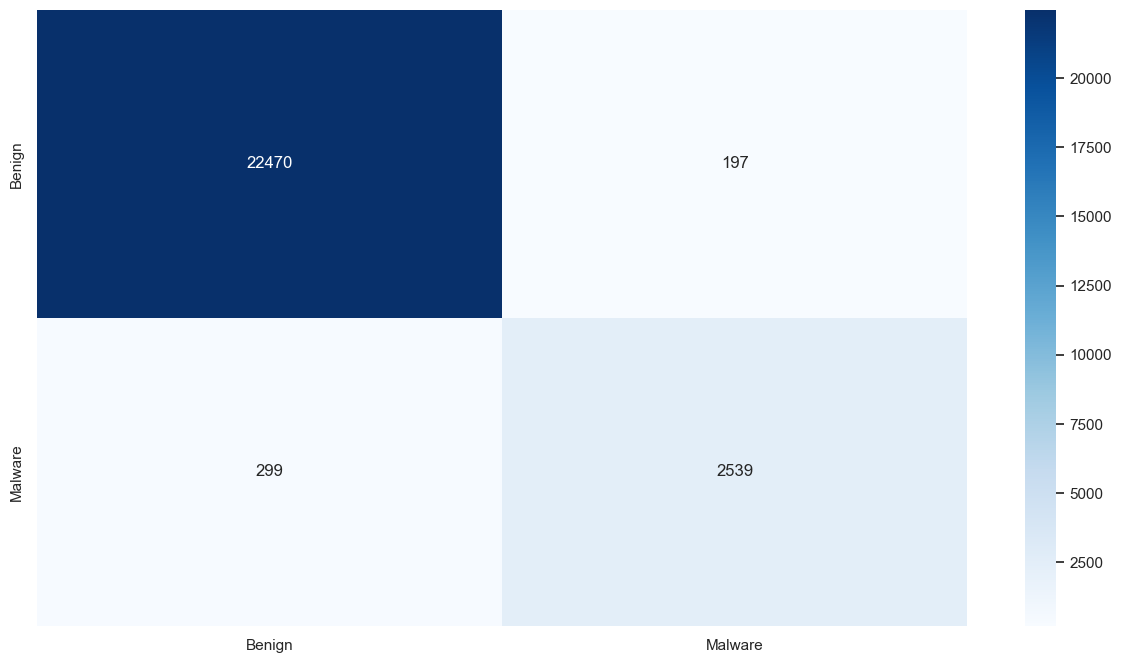

In [23]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
predictions = clf.predict(X_test)
true_labels = y_test
cf_matrix = confusion_matrix(true_labels, predictions)
clf_report = classification_report(true_labels, predictions, digits=5)
heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(clf_report)

In [24]:
# # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# from sklearn.model_selection import GridSearchCV

# # We choose our model of choice and set it's hyper parameters you can change anything
# rfc = RandomForestClassifier()

# parameters = {"n_estimators": [100,200,275,300,350,400]}

# # GridSearchCV is a technique for finding the optimal parameter values from a given set of parameters in a grid
# rfc = GridSearchCV(rfc, parameters)
# # Train Model
# rfc.fit(X_train, y_train)

# # # Check data balance and variety
# print(sorted(Counter(y_train).items()))
# rfc = rfc.best_estimator_
# ResultPrintout(rfc)

C:\Users\97252\anaconda3\lib\site-packages\xgboost\compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


RandomForestClassifier(class_weight='balanced', random_state=42)
              precision    recall  f1-score   support

      Benign    0.99833   0.95054   0.97385     22667
     Malware    0.71425   0.98732   0.82887      2838

    accuracy                        0.95464     25505
   macro avg    0.85629   0.96893   0.90136     25505
weighted avg    0.96672   0.95464   0.95772     25505

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
              precision   

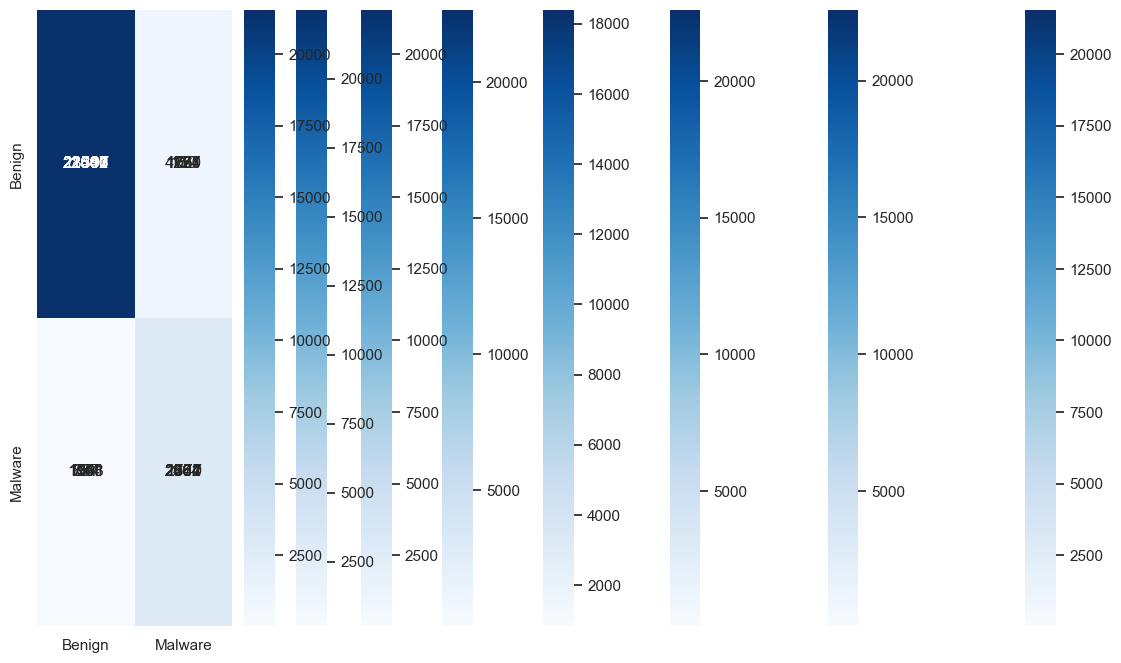

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from timeit import timeit
import xgboost 
import sklearn
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline

Logistic_Regression =  LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')

Decision_Tree =DecisionTreeClassifier(random_state=42, class_weight='balanced')

Random_Forest =  RandomForestClassifier(random_state=42, class_weight='balanced')

Extra_Trees=  ExtraTreesClassifier(random_state=42, class_weight='balanced')

Gradient_Boosting =  GradientBoostingClassifier(random_state=42)

Hist_Gradient_Boosting =  HistGradientBoostingClassifier(random_state=42)

AdaBoost = AdaBoostClassifier(random_state=42)


# SVC =SVC(class_weight='balanced', random_state=42)


xgb=xgboost.sklearn.XGBClassifier(max_depth=2)
models={xgb,Logistic_Regression,Decision_Tree,Random_Forest,Extra_Trees,Gradient_Boosting,Hist_Gradient_Boosting,AdaBoost}

for model in models:   
    # Train Model
    model.fit(X_train, y_train)
    print(model)
    # # Check data balance and variety
    ResultPrintout(model)


In [26]:
# # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
# from sklearn.ensemble import HistGradientBoostingClassifier
# # We choose our model of choice and set it's hyper parameters you can change anything
# hgbc = HistGradientBoostingClassifier()

# #  The random_state in these algorithms controls the randomness involved during the node splitting process by searching for the best feature
# parameters = {"min_samples_leaf": [10,20,50],
#               "max_iter":[1,2,3]
#              }

# # GridSearchCV is a technique for finding the optimal parameter values from a given set of parameters in a grid
# hgbc = GridSearchCV(hgbc, parameters)
# # Train Model
# hgbc.fit(X_train, y_train)

# # # Check data balance and variety
# print(sorted(Counter(y_train).items()))
# hgbc = hgbc.best_estimator_
# ResultPrintout(hgbc)

# Test

In [27]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
from sklearn.metrics import accuracy_score
best=0
m=None
models={clf,xgb,Gradient_Boosting,Logistic_Regression,Decision_Tree,Random_Forest,Extra_Trees,Gradient_Boosting,Hist_Gradient_Boosting,AdaBoost}
for i in models:
    print(i)
    sns.set(rc={'figure.figsize':(15,8)})
    predictions = i.predict(X_test)
    true_labels = y_test
    print(accuracy_score(true_labels, predictions)*100)
    if accuracy_score(true_labels, predictions)*100 > best:
        best=accuracy_score(true_labels, predictions)*100
        m=i
#         print(best)
#         print(m)
        
print("-------")
print(best)
print(m)

RandomForestClassifier(class_weight='balanced', random_state=42)
95.46363458145461
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
96.74573613017056
AdaBoostClassifier(random_state=42)
95.16173299353068
RandomForestClassifier()
98.05528327778867
LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
79.97647520094098
GradientBoostingClassifier(random_state=42)
95.70280337188787
DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [28]:
with open(f'./dataset_{str(dataset_number)}_val.json') as file:
    raw_ds = json.load(file)
test_df = pd.json_normalize(raw_ds, max_level=2)

# Preprocess the validation dataset, remember that here you don't have the labels
for column in test_df.columns[test_df.isna().any()].tolist():
    #df.drop(column, axis=1, inplace=True)
    test_df[column] = test_df[column].fillna('None')
test_df = vectorize_df(test_df)
# change_url(test_df)
# Predict with your model
X = test_df[features_list].to_numpy()
# for i in X.length():
#     if X[i] == 'none':
#         X[i] = 0
print(m)
predictions = m.predict(X)


RandomForestClassifier()


              precision    recall  f1-score   support

      Benign    0.98687   0.99131   0.98908     22667
     Malware    0.92800   0.89464   0.91102      2838

    accuracy                        0.98055     25505
   macro avg    0.95743   0.94298   0.95005     25505
weighted avg    0.98032   0.98055   0.98040     25505



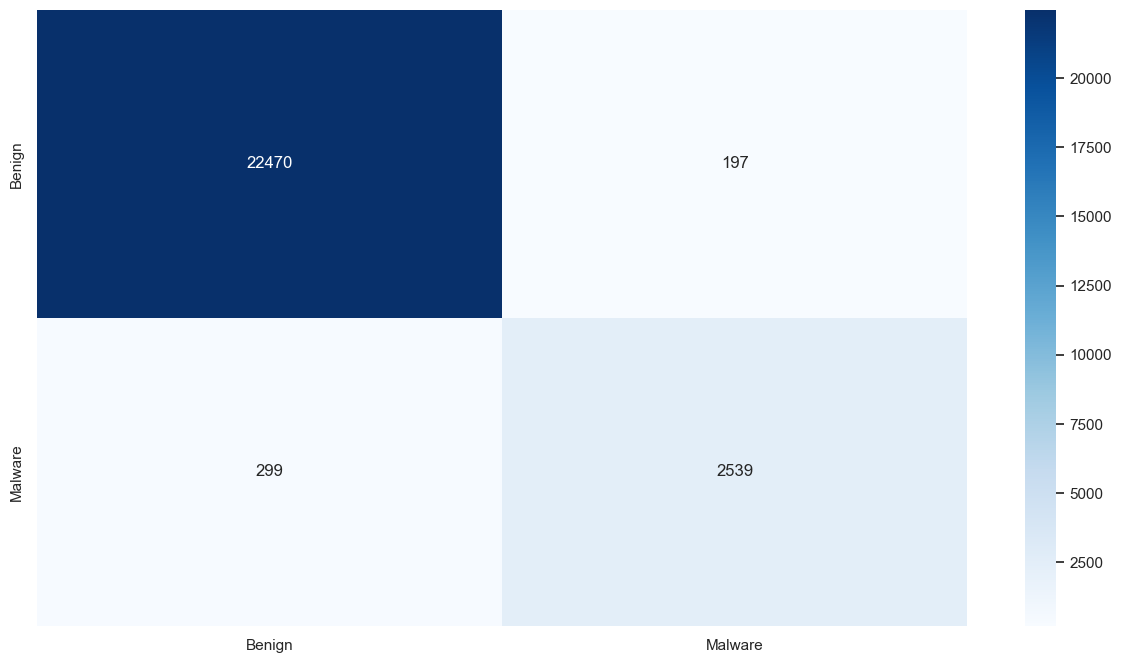

In [31]:
ResultPrintout(m)

# Save your predictions

In [30]:
# Save your preditions
enc = LabelEncoder()
np.savetxt(f'./dataset_{str(dataset_number)}_{test_type}_result.txt', enc.fit_transform(predictions), fmt='%2d')